In [27]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [28]:
#generate the sample
def gen_data():
    N = 1000
    beta = 3
    x = np.random.normal(loc=0, scale=1, size=N)
    e = np.random.logistic(size=N)
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,N

In [29]:
yn,xn, N = gen_data()


model1 = sm.Logit(yn,sm.add_constant(xn))
model1_res = model1.fit(disp=False)

print(model1_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:                  0.4577
Time:                        10:50:33   Log-Likelihood:                -362.66
converged:                       True   LL-Null:                       -668.75
Covariance Type:            nonrobust   LLR p-value:                3.744e-135
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9656      0.104      9.285      0.000       0.762       1.169
x1             2.8125      0.180     15.638      0.000       2.460       3.165


In [31]:
class SimLogit(GenericLikelihoodModel):
    
    
    def __init__(self,*args, **kwargs):
        
        super(SimLogit, self).__init__(*args, **kwargs)
        #do the simulation 1x instead of on every step
        nsim = 2000
        np.random.seed(0)
        e = np.random.logistic(size=nsim)
        e = np.repeat(e, self.endog.shape[0])
        self.sims = e.reshape((nsim,self.endog.shape[0]))
        
    
    def loglike(self, params):
        
        exog = self.exog
        endog = self.endog
        u = np.dot(exog, params)
        
        #generate simulations
        e = self.sims
        
        #compare to each sim
        u = np.tile(u,(e.shape[0],1))
        u = u.reshape((e.shape[0],endog.shape[0]))
               
        #compute likelihood
        p0, p1 = (u<=e).mean(axis=0), (u >= e).mean(axis=0)
        p = (1-endog)*p0 +  endog*p1
        ll = np.log( np.maximum(p,.0001) )#help with numerical zeros
        
        return ll.sum() 

    
model2 = SimLogit(yn,sm.add_constant(xn))
model2_res = model2.fit(disp=False)
print(model2_res.summary())

                               SimLogit Results                               
Dep. Variable:                      y   Log-Likelihood:                -362.44
Model:                       SimLogit   AIC:                             728.9
Method:            Maximum Likelihood   BIC:                             738.7
Date:                Thu, 02 Jul 2020                                         
Time:                        10:50:34                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0802      0.002    574.324      0.000       1.076       1.084
x1             2.9610      0.005    591.084      0.0

(array([476., 331., 131.,  40.,  16.,   2.,   2.,   1.,   0.,   1.]),
 array([   26978.81293857,  1028440.64891747,  2029902.48489637,
         3031364.32087527,  4032826.15685418,  5034287.99283308,
         6035749.82881198,  7037211.66479088,  8038673.50076978,
         9040135.33674868, 10041597.17272758]),
 <a list of 10 Patch objects>)

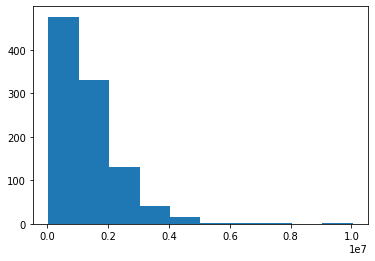

In [32]:
#comapre test distributions

hessian = np.linalg.inv( model2_res.normalized_cov_params)
values, vectors = np.linalg.eig(hessian)
np.random.seed(0)
sample  = np.random.chisquare(3, size=(1000,2) )
sample = np.dot(sample,values)


hessian = np.linalg.inv( model1_res.normalized_cov_params)
values, vectors = np.linalg.eig(hessian)
np.random.seed(0)
sample  = np.random.chisquare(3, size=(1000,2) )
sample = np.dot(sample,values)

plt.hist(sample)


plt.hist(sample,label="sim")